In [1]:
import sqlite3
import pandas as pd
import numpy as np
import requests as r

In [2]:
con = sqlite3.connect(":memory:")
cur = con.cursor()

https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

In [3]:
data = pd.read_csv('boston.csv')
data.rename(columns = {'MDEV':'MEDV'}, inplace=True)

In [4]:
data.to_sql("boston", con, index=False, if_exists="replace")

In [5]:
pd.read_sql(
    """
    SELECT * FROM boston
    limit 5
    """,
    con,
)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


1. Выведите количество пустых значений по каждой из колонок (название колонки, кол-во пустых значений)

In [6]:
pd.read_sql(
    """
    SELECT p.name, p.'notnull'
    FROM pragma_table_info('boston') p
    """,
    con,
)

,name,notnull
0,CRIM,0
1,ZN,0
2,INDUS,0
3,CHAS,0
4,NOX,0
5,RM,0
6,AGE,0
7,DIS,0
8,RAD,0
9,TAX,0


2. Выведите количество уникальных значений по каждой из колонок (название колонки, кол-во уникальных значений)

In [7]:
pd.read_sql(
    """
    SELECT count(DISTINCT CRIM) as 'CRIM_cnt_dist', count(DISTINCT ZN) as 'ZN_cnt_dist',
    count(DISTINCT INDUS) as 'INDUS_cnt_dist', count(DISTINCT CHAS) as 'CHAS_cnt_dist',
    count(DISTINCT NOX) as 'NOX_cnt_dist', count(DISTINCT RM) as 'RM_cnt_dist', count(DISTINCT AGE) as 'AGE_cnt_dist',
    count(DISTINCT DIS) as 'DIS_cnt_dist', count(DISTINCT RAD) as 'RAD_cnt_dist',
    count(DISTINCT TAX) as 'TAX_cnt_dist', count(DISTINCT PTRATIO) as 'PTRATIO_cnt_dist',
    count(DISTINCT B) as 'B_cnt_dist', count(DISTINCT LSTAT) as 'LSTAT_cnt_dist',
    count(DISTINCT MEDV) as 'MEDV_cnt_dist'
    FROM boston
    """,
    con,
)

,CRIM_cnt_dist,ZN_cnt_dist,INDUS_cnt_dist,CHAS_cnt_dist,NOX_cnt_dist,RM_cnt_dist,AGE_cnt_dist,DIS_cnt_dist,RAD_cnt_dist,TAX_cnt_dist,PTRATIO_cnt_dist,B_cnt_dist,LSTAT_cnt_dist,MEDV_cnt_dist
0,504,26,76,2,81,446,356,412,9,66,46,357,455,229


3. Выведите колонки, у которых медиана равна минимальному значению (название колонки).
Напишите какой вывод можно сделать по данным в этих колонках

In [8]:
for i in data.columns:
    sql = f"""
    SELECT 
      CASE
      WHEN (SELECT MIN({i}) FROM boston) = (SELECT {i} FROM boston ORDER BY {i} LIMIT 1 OFFSET (SELECT COUNT(*) FROM boston) / 2) THEN ('{i}') ELSE 0
      END as t;
    """
    cur.execute(sql)
    res = cur.fetchall()[0][0]
    if res != 0:
        print(res)

ZN
CHAS


Не менее 50% домов находяться не у реки и доля земель под жилую застройку зонирована под участки площадью более 25 000 кв. футов равна нулю

4. Выведите разницу между среднем количеством комнат(RM) в домах с самой дорогой стоимостью(MEDV) и 25 самыми дешевыми домами. 
Аналогично по 50, 100, 200, 300 самыми дешевыми домами. (кол-во домов(25,50,100,200,300), среднее кол-во комнат в них, среднее кол-во комнат в самых дорогих, разница).
Напишите влияет ли кол-во комнат на стоимость и как сильно.

In [9]:
pd.read_sql(
    """
    with exp as
    (SELECT RM, MEDV FROM boston order by MEDV DESC limit 1),
    poor as
    (SELECT RM FROM boston order by medv)
    select (e.RM - p.RM) as diff from poor p, exp e
    limit 25
    """,
    con,
)

,diff
0,2.036
1,1.806
2,1.502
3,1.637
4,2.970
5,2.075
6,2.212
7,1.146
8,1.055
9,2.489


In [10]:
for s in [25,50,100,200,300]:
    sql = f"""
    with exp as
    (SELECT RM, MEDV FROM boston order by MEDV DESC limit 1),
    poor as
    (SELECT RM FROM boston order by medv)
    select (e.RM - p.RM) as diff from poor p, exp e
    limit {s}
    """
    cur.execute(sql)
    df = pd.DataFrame(cur.fetchall(), columns=[s])
    print(df)

       25
0   2.036
1   1.806
2   1.502
3   1.637
4   2.970
5   2.075
6   2.212
7   1.146
8   1.055
9   2.489
10  0.707
11  2.396
12  2.140
13  1.593
14  0.665
15  1.554
16  1.742
17  1.958
18  1.337
19  3.121
20  1.532
21  1.109
22  1.028
23  2.453
24  1.266
       50
0   2.036
1   1.806
2   1.502
3   1.637
4   2.970
5   2.075
6   2.212
7   1.146
8   1.055
9   2.489
10  0.707
11  2.396
12  2.140
13  1.593
14  0.665
15  1.554
16  1.742
17  1.958
18  1.337
19  3.121
20  1.532
21  1.109
22  1.028
23  2.453
24  1.266
25  2.609
26  1.652
27  0.521
28  2.185
29  2.837
30  1.671
31  1.635
32  0.944
33  1.287
34  1.296
35  1.953
36  2.099
37  1.924
38  1.281
39  2.586
40  1.030
41  3.351
42  1.459
43  2.185
44  1.085
45  1.969
46  1.084
47  1.238
48  1.776
49  1.602
      100
0   2.036
1   1.806
2   1.502
3   1.637
4   2.970
..    ...
95  0.176
96  1.732
97  1.776
98  1.347
99  0.834

[100 rows x 1 columns]
       200
0    2.036
1    1.806
2    1.502
3    1.637
4    2.970
..     ...
195  1.17

AxesSubplot(0.125,0.125;0.775x0.755)


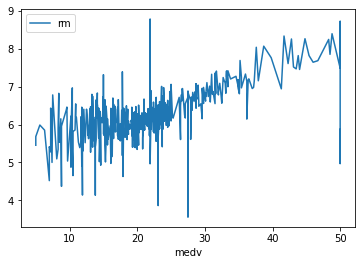

In [11]:
sql = f"""
select RM, MEDV FROM boston order by MEDV

"""
cur.execute(sql)
df = pd.DataFrame(cur.fetchall(), columns=['rm', 'medv'])
print(df.plot(x='medv', y='rm'))

В среднем с увеличением кол-ва комнат возрастает стоимомость

5. Выведите ранги значений колонки LSTAT(процент населения с более низким статусом) в домах с самой дорогой стоимостью (значение LSTAT, стоимость, ранг). Напишите какой вывод можно сделать по этим данным.

In [12]:
pd.read_sql(
    """
    with exp as
    (SELECT RM, MEDV FROM boston order by MEDV DESC limit 1),
    ranks as
    (select RM, MEDV, LSTAT, dense_rank() OVER(ORDER BY LSTAT DESC) as rank from boston )
    select ranks.LSTAT, ranks.MEDV, ranks.rank from ranks, exp
    where ranks.MEDV = exp.MEDV 
    
    """,
    con,
)

,LSTAT,MEDV,rank
0,9.53,50.0,280
1,8.88,50.0,301
2,7.44,50.0,334
3,5.12,50.0,397
4,4.63,50.0,414
5,4.45,50.0,420
6,3.73,50.0,432
7,3.70,50.0,433
8,3.32,50.0,440
9,3.26,50.0,441


Процент населения с низким статусом меньше в домах с самой дорогой стоимостью

6. Выведите среднюю стоимость домов граничащих с рекой(CHAS) и нет (граничит/не граничит, стоимость)

In [13]:
pd.read_sql(
    """
    with with_river as
    (SELECT AVG(MEDV) as with_r FROM boston WHERE CHAS = 1),
    without_river as
    (SELECT AVG(MEDV) as without_r FROM boston WHERE CHAS = 0)
    SELECT with_r, without_r FROM with_river, without_river
    """,
    con,
)

,with_r,without_r
0,28.44,22.093843


7. Выведите все колонки, у которых среднее значение выше, когда дом граничит с рекой (название колонки). Напишите какой вывод можно сделать по этим данным.

In [14]:
for i in data.columns:
    sql = f"""
    SELECT 
      CASE
      WHEN (SELECT AVG({i}) FROM boston WHERE CHAS = 1) > (SELECT AVG({i}) FROM boston WHERE CHAS = 0) THEN ('{i}') ELSE 0
      END as t;
    """
    cur.execute(sql)
    res = cur.fetchall()[0][0]
    if res != 0:
        print(res)

INDUS
CHAS
NOX
RM
AGE
B
MEDV


Преступность меньше из-за более высокого статуса населения, проживающий в более дорогих домах с большим количеством комнат. На побережье преобладают дома построенные до 1940г. До центра города добираться дольше.

8. Выведите значения долей промышленной застройки(INDUS), концентрации оксидов азота(NOX) и по их перцентилям - 10, 20 ... 100 ( перцетиль(10,20...100),значение INDUS, значение NOX). Напишите прослеживается между ними взаимосвязь

In [15]:
pd.read_sql(
    """
    with indus as
    (SELECT INDUS, NTILE(10) OVER(ORDER BY INDUS) as percentile FROM boston),
    perc_indus as
    (select DISTINCT LAST_VALUE(INDUS) OVER(PARTITION BY percentile) AS 'p_indus', percentile from indus),
    nox as
    (SELECT NOX, NTILE(10) OVER(ORDER BY NOX) as percentile FROM boston),
    perc_nox as
    (select DISTINCT LAST_VALUE(NOX) OVER(PARTITION BY percentile) AS 'p_nox', percentile from nox)
    select p_indus, p_nox from perc_indus
    left join perc_nox on perc_indus.percentile = perc_nox.percentile
    """,
    con,
)

,p_indus,p_nox
0,2.89,0.426
1,4.39,0.442
2,5.96,0.472
3,7.38,0.507
4,9.69,0.538
5,13.89,0.580
6,18.10,0.609
7,18.10,0.671
8,19.58,0.713
9,27.74,0.871


Наблюдается положительная корреляция двух признаков